In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
OpenPipe client initialized
opk_6252fb0d5b5c1832334582531755e1973d6f81f62c
$ vllm serve NousResearch/Hermes-2-Theta-Llama-3-8B --block-size=32 --disable-log-requests --enable-chunked-prefill --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-num-seqs=2048 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --tool-call-parser=hermes --served-model-name=temporal-clue-001 --port=8000 --api-key=default


[W325 23:48:34.701247986 CUDAAllocatorConfig.h:28] Warning: expandable_segments not supported on this platform (function operator())
Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.44it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:01<00:01,  1.11it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:02<00:00,  1.01it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.26it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.20it/s]

INFO:     Started server process [14929]
INFO:     Waiting for application startup.
INFO:     Application startup complete.


INFO:     127.0.0.1:55424 - "POST /v1/chat/completions HTTP/1.1" 200 OK


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


vLLM server started succesfully. Logs can be found at ./logs/vllm.log


wandb: Currently logged in as: arctic_fly (based-op) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Using previous iteration 94.875 completion tokens per request as estimate


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/1600 [00:00<?, ?it/s]

/root/sky_workdir/.venv/lib/python3.12/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/root/sky_workdir/.venv/lib/python3.12/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


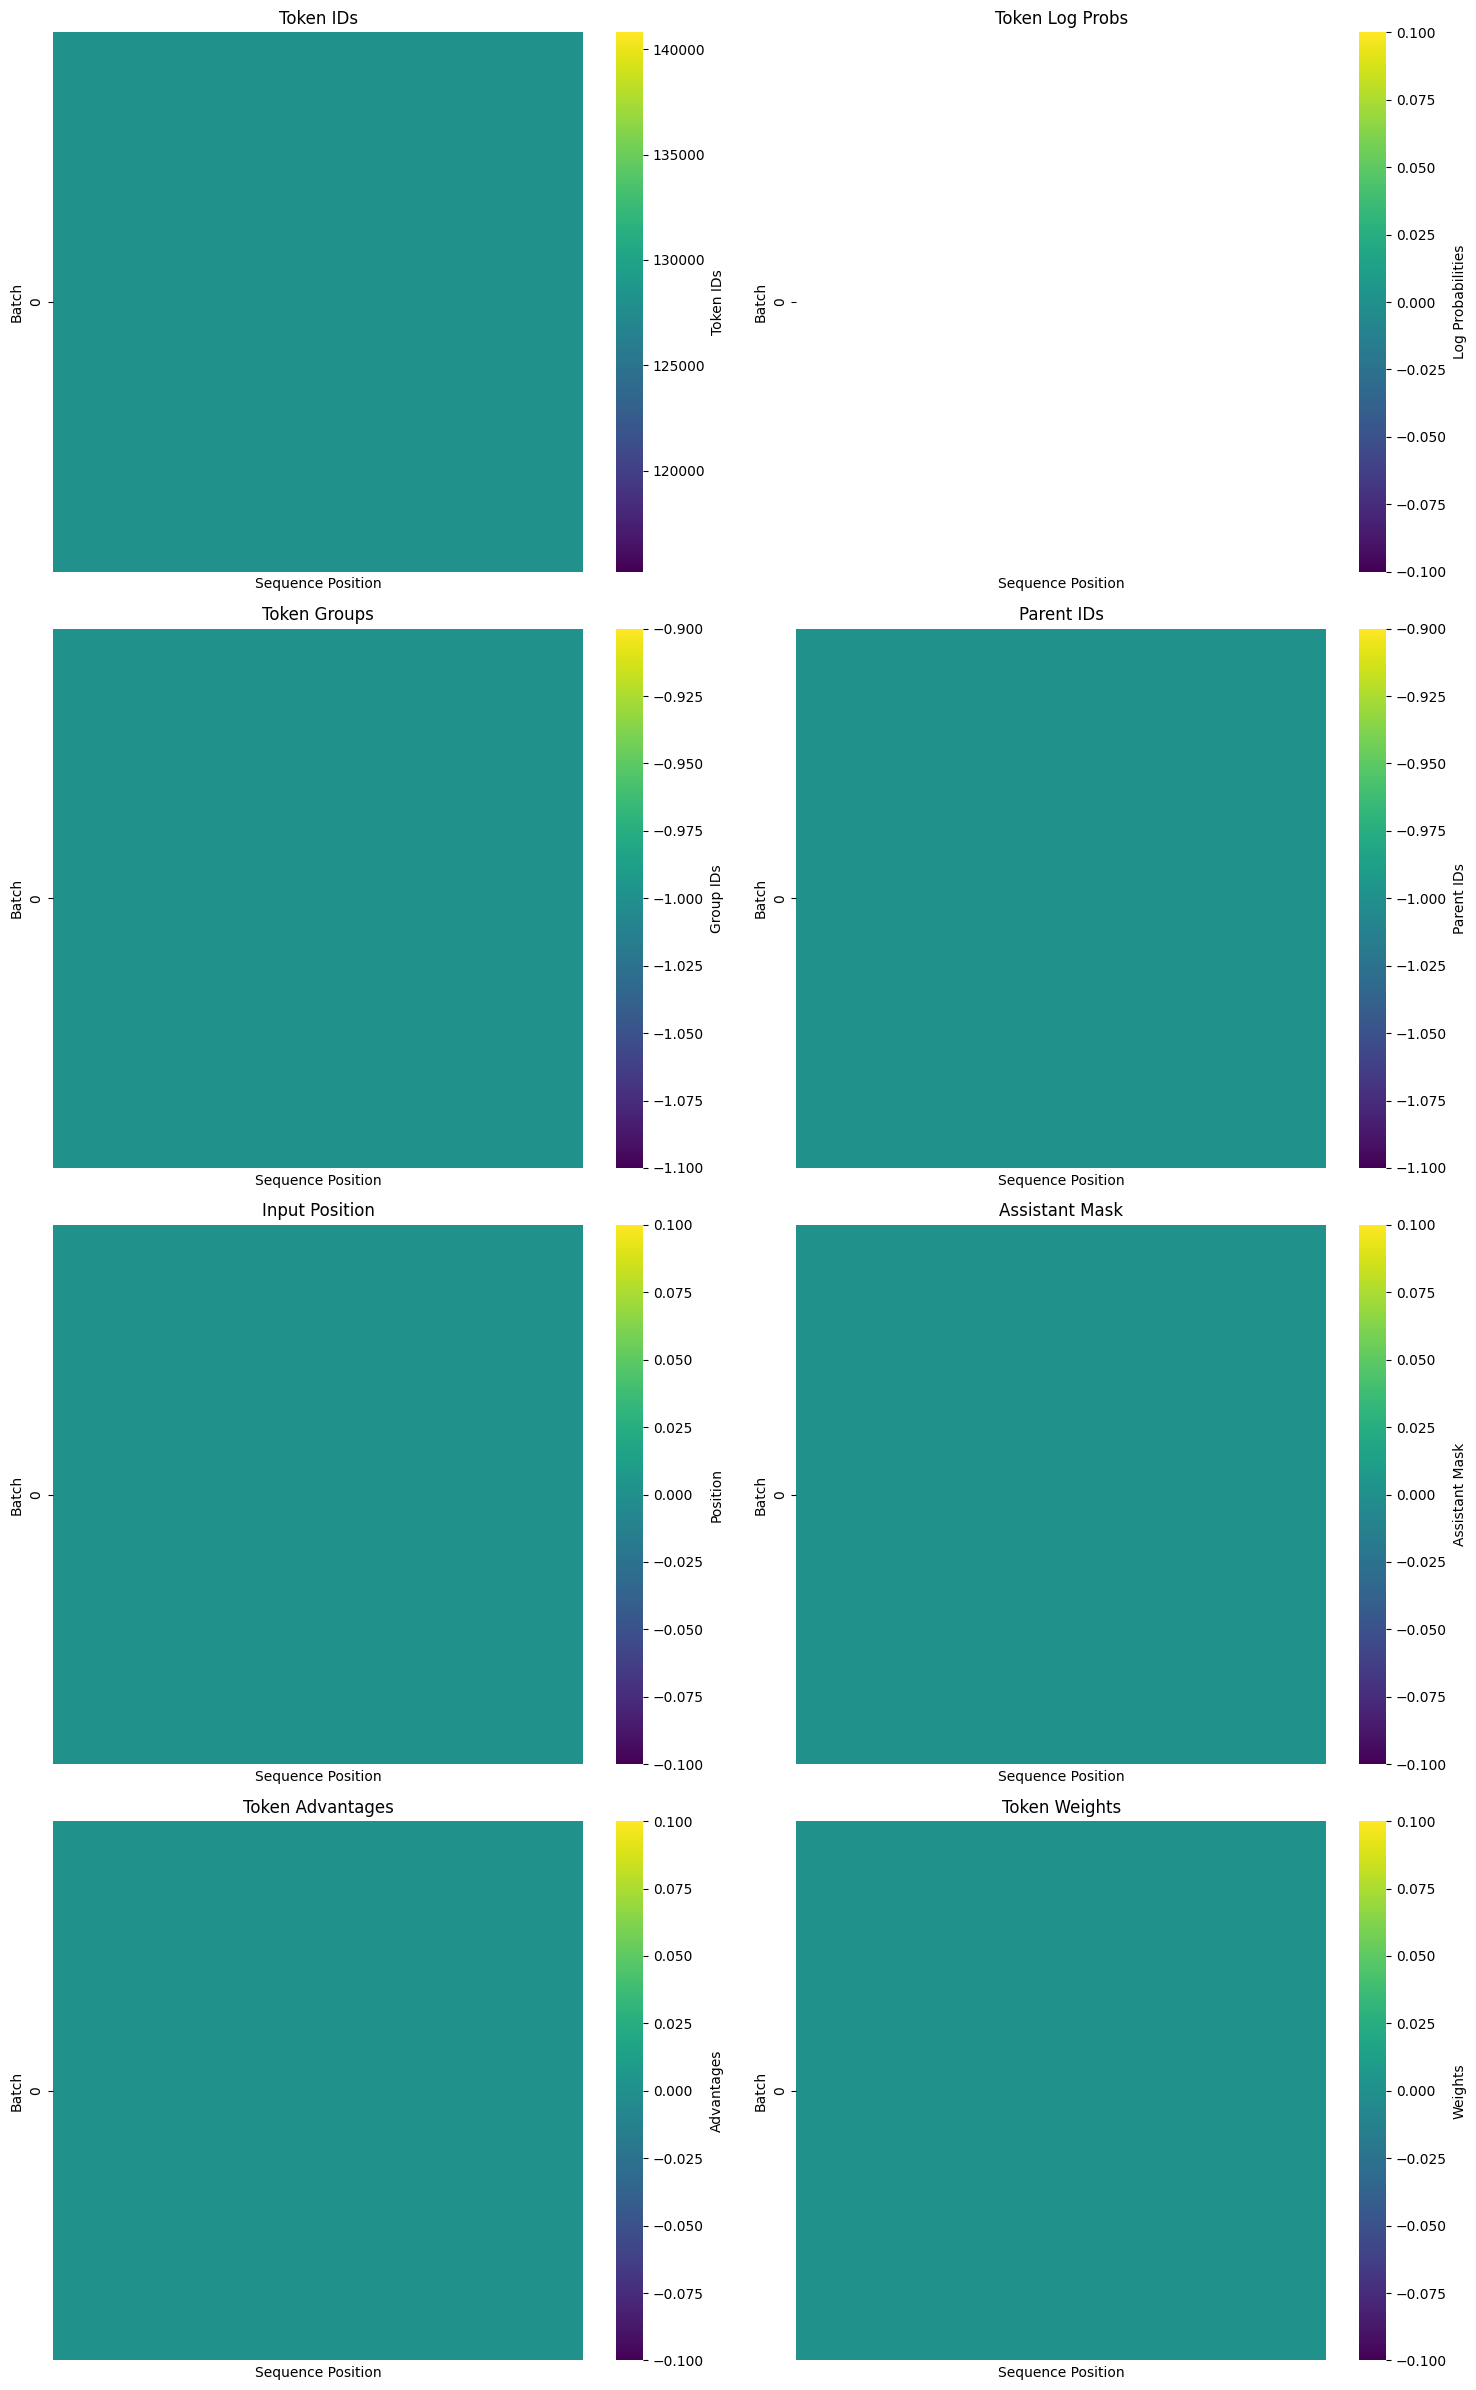

RuntimeError: output with shape [16384] doesn't match the broadcast shape [1, 16384]

In [3]:
import art
import asyncio
from dotenv import load_dotenv
import json
import openai
import random
import re
from typing import TypedDict
from openpipe.client import OpenPipe
import time
import hashlib
import os
load_dotenv()

op_client = OpenPipe()
print("OpenPipe client initialized")
print(os.environ["OPENPIPE_API_KEY"])


class TemporalCluePuzzle(TypedDict):
    num_clues: int
    prompt: str
    solution: dict[str, str]

def generate_puzzle_key(puzzle: TemporalCluePuzzle) -> str:
    # hash the puzzle prompt
    return puzzle["num_clues"] + "-" + hashlib.sha256(puzzle["prompt"].encode()).hexdigest()


puzzles: list[TemporalCluePuzzle] = json.load(open("./data/temporal-clue/puzzles.json"))
val_puzzles = puzzles[:64]
test_puzzles = puzzles[64:128]
train_puzzles = puzzles[128:]
random.seed(42)
random.shuffle(train_puzzles)


api = art.LocalAPI(wandb_project="agent-reinforcement-training")
model = await api.get_or_create_model(
    name="temporal-clue-001", base_model="NousResearch/Hermes-2-Theta-Llama-3-8B"
)


async def rollout(
    client: openai.AsyncOpenAI, puzzle: TemporalCluePuzzle, iteration: int, is_validation: bool
) -> art.Trajectory:
    puzzle_key = generate_puzzle_key(puzzle)

    messages: art.Messages = [{"role": "user", "content": puzzle["prompt"]}]
    requested_at = int(time.time() * 1000)
    chat_completion = await client.chat.completions.create(
        messages=messages, model=model.name
    )
    op_client.report(
        requested_at=requested_at,
        received_at=int(time.time() * 1000),
        req_payload={
            "model": model.name,
            "messages": messages,
        },
        resp_payload=chat_completion,
        status_code=200,
        metadata={
            "notebook-id": "temporal-clue", 
            "iteration": iteration, 
            "validation": is_validation, 
            "puzzle_key": puzzle_key,
        },
    )
    print("Should have reported to OpenPipe")
    choice = chat_completion.choices[0]
    content = choice.message.content
    assert isinstance(content, str)
    num_correct = 0
    for key, value in puzzle["solution"].items():
        if matches := re.findall(rf"{key}\. ([A-Za-z \.:-]+)", content):
            match = matches[-1]
            if match.strip().lower() == value.lower():
                num_correct += 1
    reward = acc = num_correct / len(puzzle["solution"])
    return art.Trajectory(
        messages_and_choices=[*messages, choice], reward=reward, metrics={"acc": acc}
    )


stride = 32
for i in range(await model.get_iteration(), 1_000):
    async with model.openai_client(
        estimated_completion_tokens=350, verbosity=2
    ) as openai_client:
        val_groups, train_groups = await asyncio.gather(
            art.gather_groups(
                (
                    (rollout(openai_client, puzzle, i, True) for _ in range(2))
                    for puzzle in val_puzzles
                ),
                pbar_desc="val",
                stream_chat_completions=8,
            ),
            art.gather_groups(
                (
                    (rollout(openai_client, puzzle, i, False) for _ in range(50))
                    for puzzle in train_puzzles[i * stride : (i + 1) * stride]
                ),
                pbar_desc="train",
            ),
        )
    await model.log(val_groups)
    await model.clear_iterations()
    await model.tune(
        train_groups, config=art.TuneConfig(plot_tensors=True, verbosity=2)
    )